Original Consensus Motif:  CCCTGTGTCCCGCAC
Planted Motifs:  ['CTCTTGGTCCCGCGC', 'TCCTGGGTCCCACAG', 'CCCTGTGTCTTGCTG', 'CCGGGTGTCCCTCTC', 'CACTGTGTGACGCAT', 'TTCTGCTTCCCGCAC', 'CCCTGTAACCCGACC', 'CCCTTTTTCCCGGGC', 'CCATGCGTCACGCAA', 'CACTCTGTCCCGCGG']
Found Consensus Motif:    CCTGTGTCCCGCGCC
Final Score:  47
Recovered Motifs:
TCTTGGTCCCGCGCC
CCTGGGTCCCACAGC
CCTGTGTCTTGCTGG
CGGGTGTCCCTCTCC
CCGCGCTCTCGTCAC
TCTGCTTCCCGCACC
CCTGTAACCCGACCT
CCTTTTTCCCGGGCA
CATGCGTCACGCAAT
ACTCTGTCCCGCGGG

Evaluation Metrics:
--------------------
Motif 1: Hamming Distance = 10, Accuracy = 0.33
Motif 2: Hamming Distance = 10, Accuracy = 0.33
Motif 3: Hamming Distance = 11, Accuracy = 0.27
Motif 4: Hamming Distance = 9, Accuracy = 0.40
Motif 5: Hamming Distance = 11, Accuracy = 0.27
Motif 6: Hamming Distance = 10, Accuracy = 0.33
Motif 7: Hamming Distance = 9, Accuracy = 0.40
Motif 8: Hamming Distance = 5, Accuracy = 0.67
Motif 9: Hamming Distance = 13, Accuracy = 0.13
Motif 10: Hamming Distance = 11, Accuracy

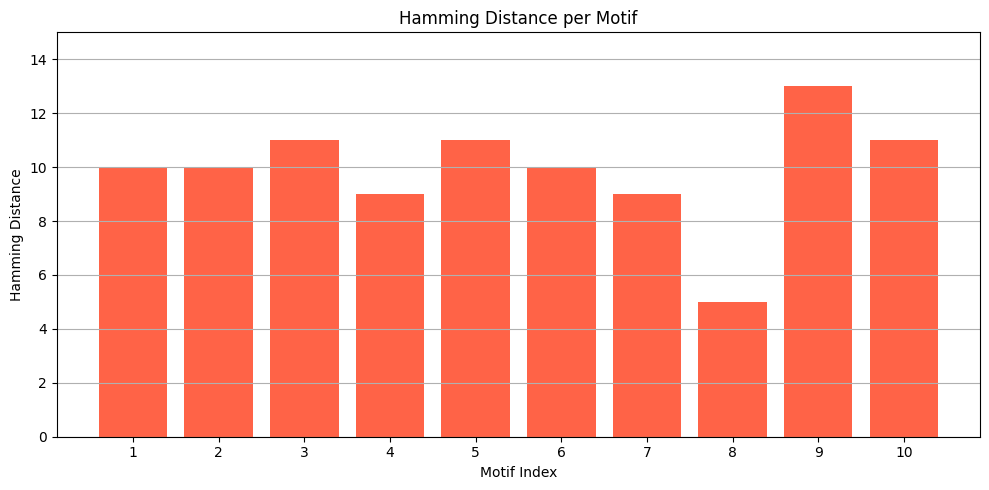

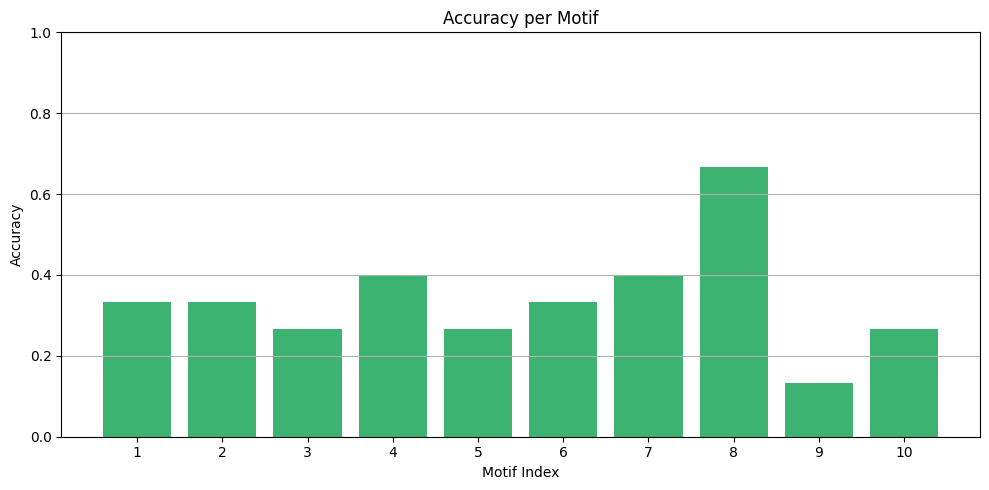

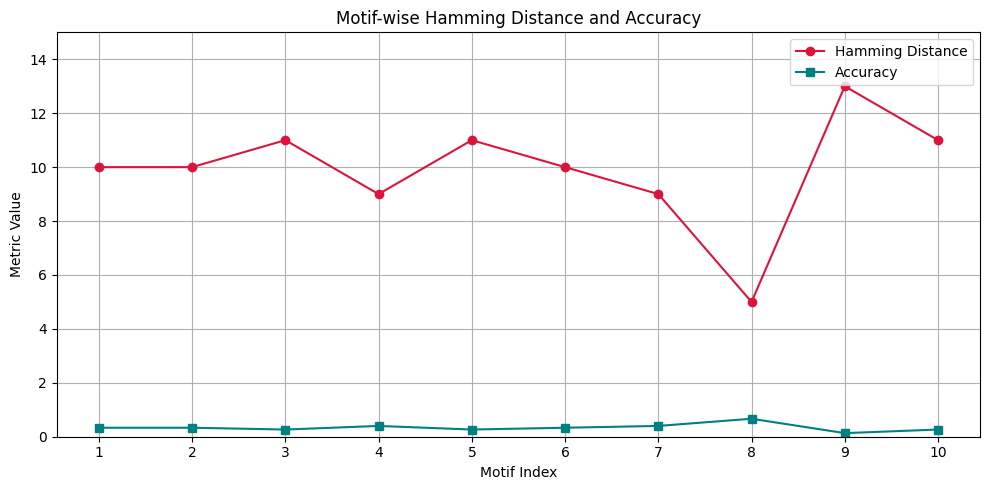

In [ ]:
import random
from collections import Counter

# Parameters
t = 10  # number of DNA strings
N = 100  # length of each string
k = 15  # motif length
d = 4   # max mutations

# DNA alphabet
nucleotides = ['A', 'C', 'G', 'T']

# Function to mutate a motif at up to d positions
def mutate_motif(motif, d):
    motif = list(motif)
    positions = random.sample(range(len(motif)), d)
    for pos in positions:
        original = motif[pos]
        motif[pos] = random.choice([n for n in nucleotides if n != original])
    return ''.join(motif)

# Generate consensus motif
def generate_consensus_motif(k):
    return ''.join(random.choice(nucleotides) for _ in range(k))

# Generate dataset with implanted motifs
def generate_dataset(t, N, k, d):
    sequences = []
    planted_motifs = []
    consensus = generate_consensus_motif(k)

    for _ in range(t):
        seq = list(''.join(random.choice(nucleotides) for _ in range(N)))
        mutated_motif = mutate_motif(consensus, d)
        start = random.randint(0, N - k)
        seq[start:start+k] = list(mutated_motif)
        sequences.append(''.join(seq))
        planted_motifs.append(mutated_motif)

    return sequences, planted_motifs, consensus

# Score motifs based on consensus
def score_motifs(motifs):
    consensus = ''
    for i in range(len(motifs[0])):
        col = [motif[i] for motif in motifs]
        most_common = Counter(col).most_common(1)[0][0]
        consensus += most_common
    score = sum(sum(1 for i in range(len(motif)) if motif[i] != consensus[i]) for motif in motifs)
    return score, consensus

# Build profile with pseudocounts
def build_profile(motifs):
    profile = {'A': [], 'C': [], 'G': [], 'T': []}
    k = len(motifs[0])
    for i in range(k):
        counts = Counter(motif[i] for motif in motifs)
        for base in nucleotides:
            profile[base].append((counts[base] + 1) / (len(motifs) + 4))  # pseudocounts
    return profile

# Find most probable k-mer in a sequence using a profile
def most_probable_kmer(seq, k, profile):
    max_prob = -1
    best_kmer = seq[0:k]
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        prob = 1
        for j, char in enumerate(kmer):
            prob *= profile[char][j]
        if prob > max_prob:
            max_prob = prob
            best_kmer = kmer
    return best_kmer

# Randomized Motif Search
def randomized_motif_search(sequences, k, iterations=1000):
    best_motifs = [random.choice([seq[i:i+k] for i in range(len(seq) - k + 1)]) for seq in sequences]
    best_score, _ = score_motifs(best_motifs)

    for _ in range(iterations):
        motifs = [random.choice([seq[i:i+k] for i in range(len(seq) - k + 1)]) for seq in sequences]
        while True:
            profile = build_profile(motifs)
            new_motifs = [most_probable_kmer(seq, k, profile) for seq in sequences]
            new_score, _ = score_motifs(new_motifs)
            if new_score < best_score:
                best_score = new_score
                best_motifs = new_motifs
                motifs = new_motifs
            else:
                break

    final_score, consensus = score_motifs(best_motifs)
    return best_motifs, final_score, consensus

# Run the setup and algorithm
sequences, planted_motifs, original_consensus = generate_dataset(t, N, k, d)
found_motifs, final_score, found_consensus = randomized_motif_search(sequences, k)

print("Original Consensus Motif: ", original_consensus)
print("Planted Motifs: ", planted_motifs)
print("Found Consensus Motif:   ", found_consensus)
print("Final Score: ", final_score)
print("Recovered Motifs:")
for motif in found_motifs:
    print(motif)

    # Function to calculate Hamming distance
def hamming_distance(s1, s2):
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

# Calculate metrics
total_correct = 0
total_possible = t * k  # total characters in all motifs
total_hamming = 0

accuracies = []
hamming_distances = []

for planted, recovered in zip(planted_motifs, found_motifs):
    dist = hamming_distance(planted, recovered)
    hamming_distances.append(dist)
    accuracy = (k - dist) / k
    accuracies.append(accuracy)

    total_correct += (k - dist)
    total_hamming += dist

# Overall metrics
average_hamming = total_hamming / t
average_accuracy = sum(accuracies) / t
recall = total_correct / total_possible

# Print evaluation results
print("\nEvaluation Metrics:")
print("--------------------")
for i, (dist, acc) in enumerate(zip(hamming_distances, accuracies), 1):
    print(f"Motif {i}: Hamming Distance = {dist}, Accuracy = {acc:.2f}")

print("\nOverall Average Hamming Distance:", round(average_hamming, 2))
print("Overall Average Accuracy:", round(average_accuracy, 2))
print("Overall Recall:", round(recall, 2))

import matplotlib.pyplot as plt

# Motif indices
motif_indices = list(range(1, t + 1))

# Plot Hamming Distances
plt.figure(figsize=(10, 5))
plt.bar(motif_indices, hamming_distances, color='tomato')
plt.title("Hamming Distance per Motif")
plt.xlabel("Motif Index")
plt.ylabel("Hamming Distance")
plt.xticks(motif_indices)
plt.ylim(0, k)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot Accuracies
plt.figure(figsize=(10, 5))
plt.bar(motif_indices, accuracies, color='mediumseagreen')
plt.title("Accuracy per Motif")
plt.xlabel("Motif Index")
plt.ylabel("Accuracy")
plt.xticks(motif_indices)
plt.ylim(0, 1.0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot Overall Trends (Line Chart)
plt.figure(figsize=(10, 5))
plt.plot(motif_indices, hamming_distances, marker='o', label='Hamming Distance', color='crimson')
plt.plot(motif_indices, accuracies, marker='s', label='Accuracy', color='teal')
plt.title("Motif-wise Hamming Distance and Accuracy")
plt.xlabel("Motif Index")
plt.ylabel("Metric Value")
plt.xticks(motif_indices)
plt.ylim(0, max(k, 1.0))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Original Consensus Motif:  CAAATACTGTTATAA
Planted Motifs:  ['ATCAGACGGTTACTC', 'AAACGACTTCCTTAC', 'CAGTACCCGCTAGCA', 'CCACTCTCGAAATTA', 'CAGCGAGTATCTGAA', 'GAATTACTGGCTCCG', 'CGTATACCAATAATT', 'AATGTATTTATAGTA', 'CCAACCTACTGACAA', 'CTACTCCTACTGTCG']
Found Consensus Motif:    CGACTATCTAAGTAA
Final Score:  57
Recovered Motifs:
CGTCCATCTAATTAG
CGACTTCCTTACGTG
AAAGATCCTCAGTAC
CCACTCTCGAAATTA
CGAGTATCTGAATAT
TGTGTATTCAAGTAA
TCCGTATACCAATAA
GAATTTTCTGTTTAA
TTACTATCTATGTAA
CTTTTTATTAAGTAA

Evaluation Metrics:
-------------------
Motif 1: Hamming Distance = 14, Accuracy = 0.07
Motif 2: Hamming Distance = 11, Accuracy = 0.27
Motif 3: Hamming Distance = 10, Accuracy = 0.33
Motif 4: Hamming Distance = 0, Accuracy = 1.00
Motif 5: Hamming Distance = 12, Accuracy = 0.20
Motif 6: Hamming Distance = 12, Accuracy = 0.20
Motif 7: Hamming Distance = 12, Accuracy = 0.20
Motif 8: Hamming Distance = 9, Accuracy = 0.40
Motif 9: Hamming Distance = 11, Accuracy = 0.27
Motif 10: Hamming Distance = 9, Accuracy 

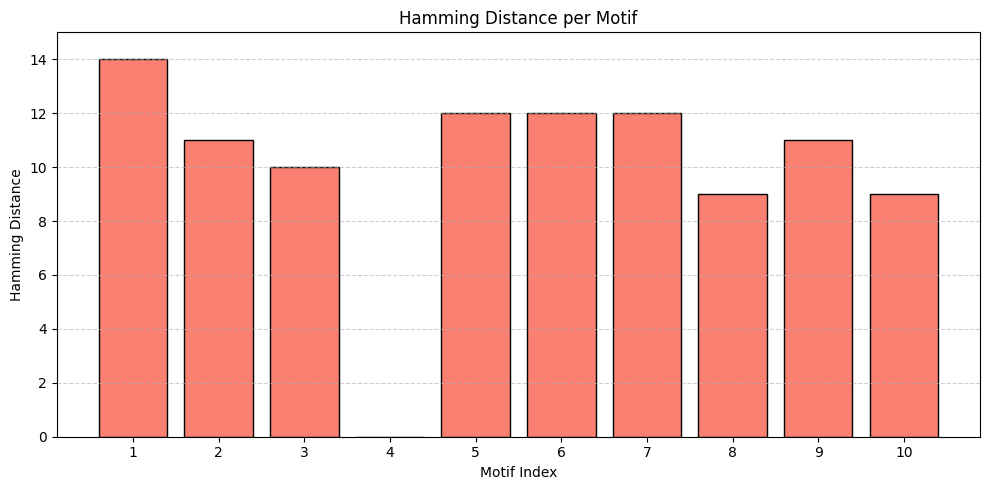

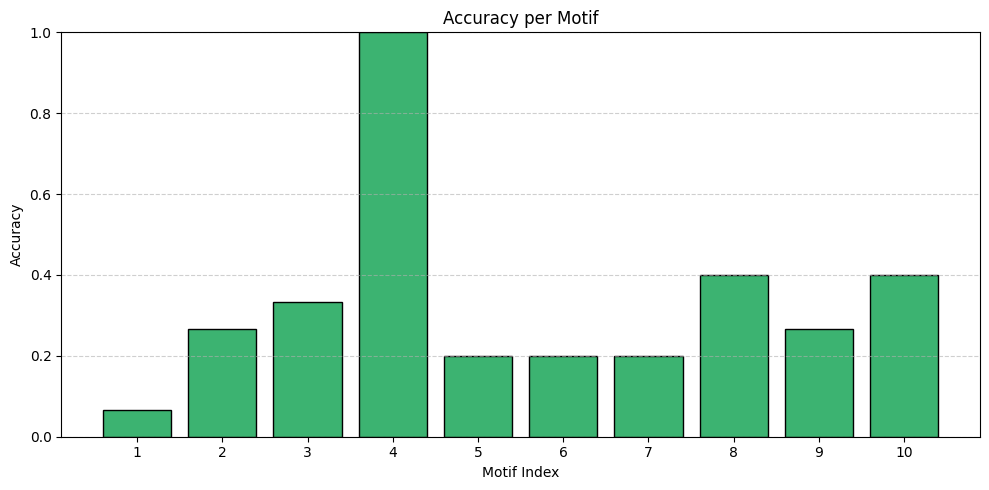

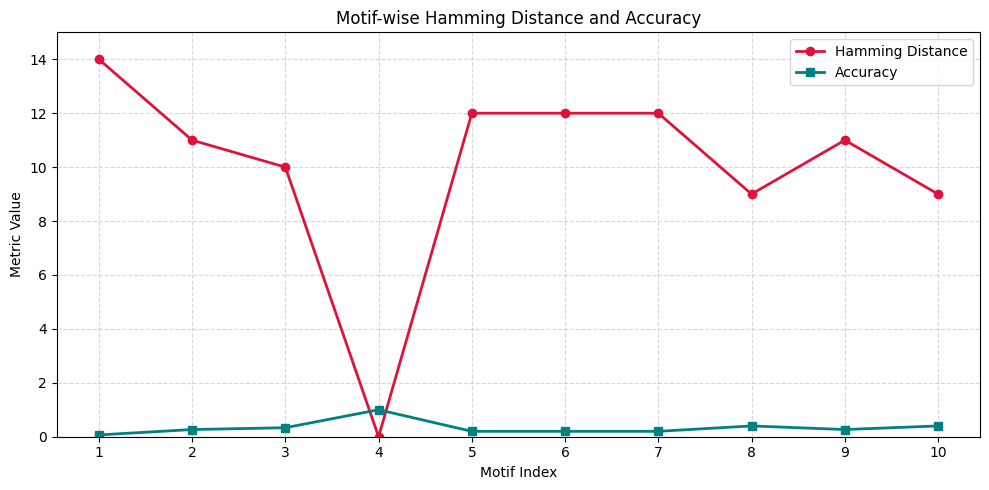

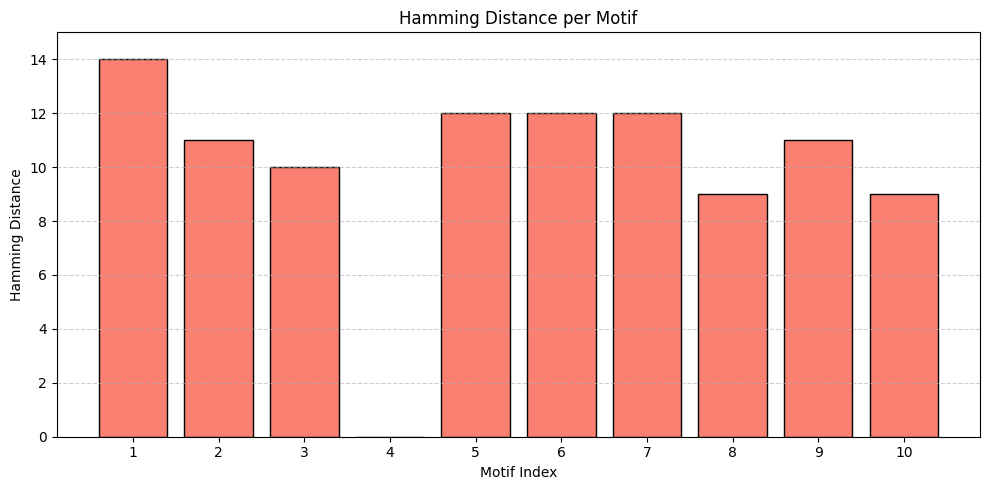

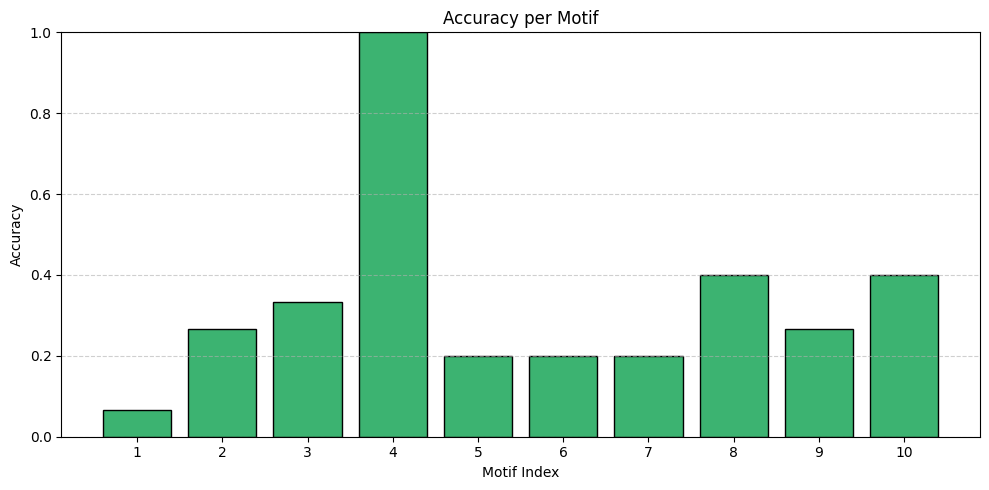

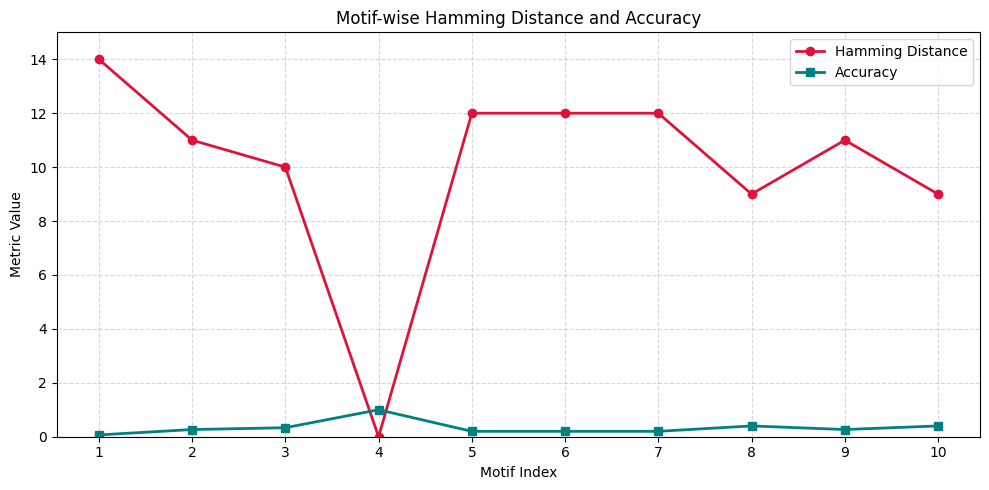

In [ ]:
import random
from collections import Counter

# Parameters
t = 10  # number of DNA strings
N = 100  # length of each string
k = 15  # motif length
d = 8   # max mutations

# DNA alphabet
nucleotides = ['A', 'C', 'G', 'T']

# Function to mutate a motif at up to d positions
def mutate_motif(motif, d):
    motif = list(motif)
    positions = random.sample(range(len(motif)), d)
    for pos in positions:
        original = motif[pos]
        motif[pos] = random.choice([n for n in nucleotides if n != original])
    return ''.join(motif)

# Generate consensus motif
def generate_consensus_motif(k):
    return ''.join(random.choice(nucleotides) for _ in range(k))

# Generate dataset with implanted motifs
def generate_dataset(t, N, k, d):
    sequences = []
    planted_motifs = []
    consensus = generate_consensus_motif(k)

    for _ in range(t):
        seq = list(''.join(random.choice(nucleotides) for _ in range(N)))
        mutated_motif = mutate_motif(consensus, d)
        start = random.randint(0, N - k)
        seq[start:start+k] = list(mutated_motif)
        sequences.append(''.join(seq))
        planted_motifs.append(mutated_motif)

    return sequences, planted_motifs, consensus

# Score motifs based on consensus
def score_motifs(motifs):
    consensus = ''
    for i in range(len(motifs[0])):
        col = [motif[i] for motif in motifs]
        most_common = Counter(col).most_common(1)[0][0]
        consensus += most_common
    score = sum(sum(1 for i in range(len(motif)) if motif[i] != consensus[i]) for motif in motifs)
    return score, consensus

# Build profile with pseudocounts
def build_profile(motifs):
    profile = {'A': [], 'C': [], 'G': [], 'T': []}
    k = len(motifs[0])
    for i in range(k):
        counts = Counter(motif[i] for motif in motifs)
        for base in nucleotides:
            profile[base].append((counts[base] + 1) / (len(motifs) + 4))  # pseudocounts
    return profile

# Find most probable k-mer in a sequence using a profile
def most_probable_kmer(seq, k, profile):
    max_prob = -1
    best_kmer = seq[0:k]
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        prob = 1
        for j, char in enumerate(kmer):
            prob *= profile[char][j]
        if prob > max_prob:
            max_prob = prob
            best_kmer = kmer
    return best_kmer

# Randomized Motif Search
def randomized_motif_search(sequences, k, iterations=1000):
    best_motifs = [random.choice([seq[i:i+k] for i in range(len(seq) - k + 1)]) for seq in sequences]
    best_score, _ = score_motifs(best_motifs)

    for _ in range(iterations):
        motifs = [random.choice([seq[i:i+k] for i in range(len(seq) - k + 1)]) for seq in sequences]
        while True:
            profile = build_profile(motifs)
            new_motifs = [most_probable_kmer(seq, k, profile) for seq in sequences]
            new_score, _ = score_motifs(new_motifs)
            if new_score < best_score:
                best_score = new_score
                best_motifs = new_motifs
                motifs = new_motifs
            else:
                break

    final_score, consensus = score_motifs(best_motifs)
    return best_motifs, final_score, consensus

# Run the setup and algorithm
sequences, planted_motifs, original_consensus = generate_dataset(t, N, k, d)
found_motifs, final_score, found_consensus = randomized_motif_search(sequences, k)

print("Original Consensus Motif: ", original_consensus)
print("Planted Motifs: ", planted_motifs)
print("Found Consensus Motif:   ", found_consensus)
print("Final Score: ", final_score)
print("Recovered Motifs:")
for motif in found_motifs:
    print(motif)

    # Function to calculate Hamming distance
def hamming_distance(s1, s2):
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

# Initialize evaluation stats
total_hamming = 0
total_correct = 0
total_possible = t * k
accuracies = []
hamming_distances = []

# Calculate per-motif metrics
for planted, recovered in zip(planted_motifs, found_motifs):
    dist = hamming_distance(planted, recovered)
    hamming_distances.append(dist)
    accuracy = (k - dist) / k
    accuracies.append(accuracy)
    total_hamming += dist
    total_correct += (k - dist)

# Overall metrics
average_hamming = total_hamming / t
average_accuracy = total_correct / total_possible
recall = total_correct / total_possible  # same as accuracy here

# Print detailed evaluation
print("\nEvaluation Metrics:")
print("-------------------")
for i, (dist, acc) in enumerate(zip(hamming_distances, accuracies), 1):
    print(f"Motif {i}: Hamming Distance = {dist}, Accuracy = {acc:.2f}")

print("\nOverall Average Hamming Distance:", round(average_hamming, 2))
print("Overall Accuracy:", round(average_accuracy, 2))
print("Overall Recall:", round(recall, 2))
import matplotlib.pyplot as plt

# Indices for motifs
motif_indices = list(range(1, t + 1))

# Plot 1: Hamming Distance per Motif
plt.figure(figsize=(10, 5))
plt.bar(motif_indices, hamming_distances, color='salmon', edgecolor='black')
plt.title("Hamming Distance per Motif")
plt.xlabel("Motif Index")
plt.ylabel("Hamming Distance")
plt.ylim(0, k)
plt.xticks(motif_indices)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot 2: Accuracy per Motif
plt.figure(figsize=(10, 5))
plt.bar(motif_indices, accuracies, color='mediumseagreen', edgecolor='black')
plt.title("Accuracy per Motif")
plt.xlabel("Motif Index")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.xticks(motif_indices)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot 3: Combined Line Plot
plt.figure(figsize=(10, 5))
plt.plot(motif_indices, hamming_distances, marker='o', label='Hamming Distance', color='crimson', linewidth=2)
plt.plot(motif_indices, accuracies, marker='s', label='Accuracy', color='teal', linewidth=2)
plt.title("Motif-wise Hamming Distance and Accuracy")
plt.xlabel("Motif Index")
plt.ylabel("Metric Value")
plt.xticks(motif_indices)
plt.ylim(0, max(k, 1.0))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt

# Indices for motifs
motif_indices = list(range(1, t + 1))

# Plot 1: Hamming Distance per Motif
plt.figure(figsize=(10, 5))
plt.bar(motif_indices, hamming_distances, color='salmon', edgecolor='black')
plt.title("Hamming Distance per Motif")
plt.xlabel("Motif Index")
plt.ylabel("Hamming Distance")
plt.ylim(0, k)
plt.xticks(motif_indices)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot 2: Accuracy per Motif
plt.figure(figsize=(10, 5))
plt.bar(motif_indices, accuracies, color='mediumseagreen', edgecolor='black')
plt.title("Accuracy per Motif")
plt.xlabel("Motif Index")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.xticks(motif_indices)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot 3: Combined Line Plot
plt.figure(figsize=(10, 5))
plt.plot(motif_indices, hamming_distances, marker='o', label='Hamming Distance', color='crimson', linewidth=2)
plt.plot(motif_indices, accuracies, marker='s', label='Accuracy', color='teal', linewidth=2)
plt.title("Motif-wise Hamming Distance and Accuracy")
plt.xlabel("Motif Index")
plt.ylabel("Metric Value")
plt.xticks(motif_indices)
plt.ylim(0, max(k, 1.0))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




Original Consensus Motif:  TGGTAATGCTCCGTG
Planted Motifs:  ['TGGTGATGCTCCGTG', 'TGGTAATGCTCCTTG', 'TGTTAATGCTCCGTG', 'TGGTAATGCTCCGGG', 'TAGTAATGCTCCGTG', 'TGTTAATGCTCCGTG', 'TGGGAATGCTCCGTG', 'TGATAATGCTCCGTG', 'TGGTAATGCTCCGGG', 'TGGTATTGCTCCGTG']
Found Consensus Motif:    TGGTAATGCTCCGTG
Final Score:  10
Recovered Motifs:
TGGTGATGCTCCGTG
TGGTAATGCTCCTTG
TGTTAATGCTCCGTG
TGGTAATGCTCCGGG
TAGTAATGCTCCGTG
TGTTAATGCTCCGTG
TGGGAATGCTCCGTG
TGATAATGCTCCGTG
TGGTAATGCTCCGGG
TGGTATTGCTCCGTG

Evaluation Metrics (Motif-wise):
--------------------------------
Motif 1: Hamming Distance = 0, Accuracy = 1.00
Motif 2: Hamming Distance = 0, Accuracy = 1.00
Motif 3: Hamming Distance = 0, Accuracy = 1.00
Motif 4: Hamming Distance = 0, Accuracy = 1.00
Motif 5: Hamming Distance = 0, Accuracy = 1.00
Motif 6: Hamming Distance = 0, Accuracy = 1.00
Motif 7: Hamming Distance = 0, Accuracy = 1.00
Motif 8: Hamming Distance = 0, Accuracy = 1.00
Motif 9: Hamming Distance = 0, Accuracy = 1.00
Motif 10: Hamming Dist

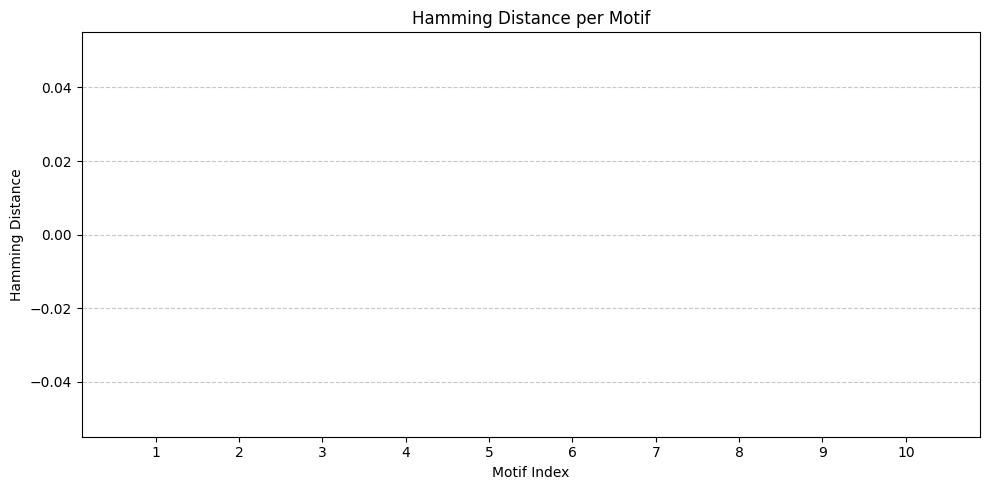

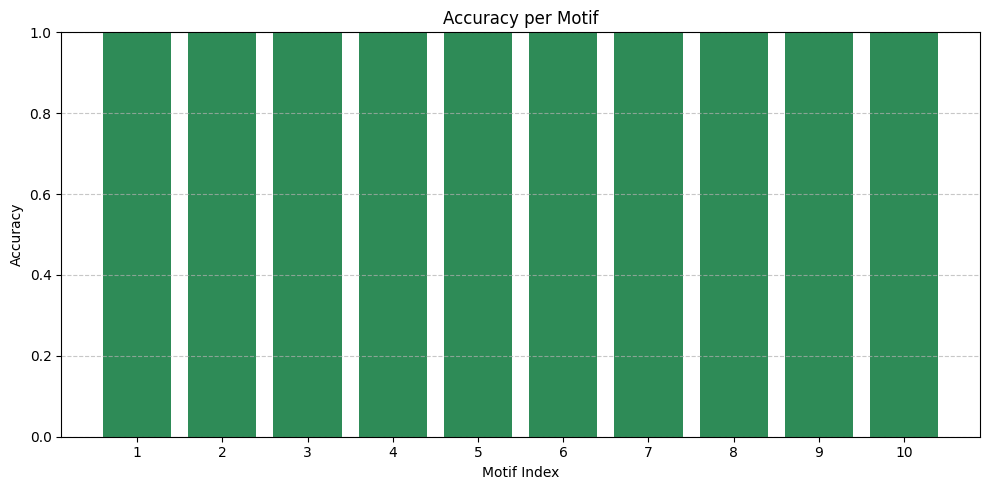

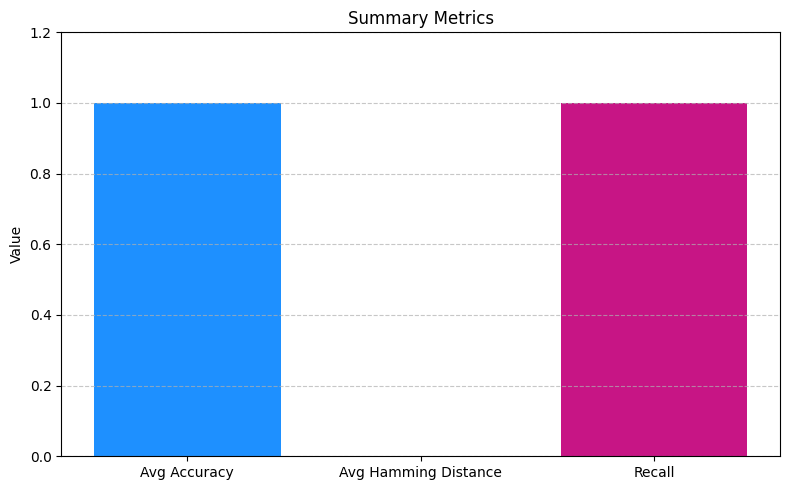

In [ ]:
import random
from collections import Counter

# Parameters
t = 10  # number of DNA strings
N = 100  # length of each string
k = 15  # motif length
d = 1   # max mutations

# DNA alphabet
nucleotides = ['A', 'C', 'G', 'T']

# Function to mutate a motif at up to d positions
def mutate_motif(motif, d):
    motif = list(motif)
    positions = random.sample(range(len(motif)), d)
    for pos in positions:
        original = motif[pos]
        motif[pos] = random.choice([n for n in nucleotides if n != original])
    return ''.join(motif)

# Generate consensus motif
def generate_consensus_motif(k):
    return ''.join(random.choice(nucleotides) for _ in range(k))

# Generate dataset with implanted motifs
def generate_dataset(t, N, k, d):
    sequences = []
    planted_motifs = []
    consensus = generate_consensus_motif(k)

    for _ in range(t):
        seq = list(''.join(random.choice(nucleotides) for _ in range(N)))
        mutated_motif = mutate_motif(consensus, d)
        start = random.randint(0, N - k)
        seq[start:start+k] = list(mutated_motif)
        sequences.append(''.join(seq))
        planted_motifs.append(mutated_motif)

    return sequences, planted_motifs, consensus

# Score motifs based on consensus
def score_motifs(motifs):
    consensus = ''
    for i in range(len(motifs[0])):
        col = [motif[i] for motif in motifs]
        most_common = Counter(col).most_common(1)[0][0]
        consensus += most_common
    score = sum(sum(1 for i in range(len(motif)) if motif[i] != consensus[i]) for motif in motifs)
    return score, consensus

# Build profile with pseudocounts
def build_profile(motifs):
    profile = {'A': [], 'C': [], 'G': [], 'T': []}
    k = len(motifs[0])
    for i in range(k):
        counts = Counter(motif[i] for motif in motifs)
        for base in nucleotides:
            profile[base].append((counts[base] + 1) / (len(motifs) + 4))  # pseudocounts
    return profile

# Find most probable k-mer in a sequence using a profile
def most_probable_kmer(seq, k, profile):
    max_prob = -1
    best_kmer = seq[0:k]
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        prob = 1
        for j, char in enumerate(kmer):
            prob *= profile[char][j]
        if prob > max_prob:
            max_prob = prob
            best_kmer = kmer
    return best_kmer

# Randomized Motif Search
def randomized_motif_search(sequences, k, iterations=1000):
    best_motifs = [random.choice([seq[i:i+k] for i in range(len(seq) - k + 1)]) for seq in sequences]
    best_score, _ = score_motifs(best_motifs)

    for _ in range(iterations):
        motifs = [random.choice([seq[i:i+k] for i in range(len(seq) - k + 1)]) for seq in sequences]
        while True:
            profile = build_profile(motifs)
            new_motifs = [most_probable_kmer(seq, k, profile) for seq in sequences]
            new_score, _ = score_motifs(new_motifs)
            if new_score < best_score:
                best_score = new_score
                best_motifs = new_motifs
                motifs = new_motifs
            else:
                break

    final_score, consensus = score_motifs(best_motifs)
    return best_motifs, final_score, consensus

# Run the setup and algorithm
sequences, planted_motifs, original_consensus = generate_dataset(t, N, k, d)
found_motifs, final_score, found_consensus = randomized_motif_search(sequences, k)

print("Original Consensus Motif: ", original_consensus)
print("Planted Motifs: ", planted_motifs)
print("Found Consensus Motif:   ", found_consensus)
print("Final Score: ", final_score)
print("Recovered Motifs:")
for motif in found_motifs:
    print(motif)
   # Function to calculate Hamming distance between two strings
def hamming_distance(s1, s2):
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

# Initialize metrics
hamming_distances = []
accuracies = []
total_correct = 0
total_positions = t * k  # total positions across all motifs

# Per-motif analysis
print("\nEvaluation Metrics (Motif-wise):")
print("--------------------------------")
for i, (planted, recovered) in enumerate(zip(planted_motifs, found_motifs), 1):
    dist = hamming_distance(planted, recovered)
    acc = (k - dist) / k
    hamming_distances.append(dist)
    accuracies.append(acc)
    total_correct += (k - dist)
    print(f"Motif {i}: Hamming Distance = {dist}, Accuracy = {acc:.2f}")

# Overall metrics
average_hamming = sum(hamming_distances) / t
average_accuracy = sum(accuracies) / t
recall = total_correct / total_positions  # Recall = (correct positions / total positions)

print("\nSummary:")
print("--------")
print("Average Hamming Distance:", round(average_hamming, 2))
print("Average Accuracy:", round(average_accuracy, 2))
print("Overall Recall:", round(recall, 2))
import matplotlib.pyplot as plt

# Plot Hamming Distance per Motif
plt.figure(figsize=(10, 5))
plt.bar(range(1, t+1), hamming_distances, color='salmon')
plt.xlabel('Motif Index')
plt.ylabel('Hamming Distance')
plt.title('Hamming Distance per Motif')
plt.xticks(range(1, t+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot Accuracy per Motif
plt.figure(figsize=(10, 5))
plt.bar(range(1, t+1), accuracies, color='seagreen')
plt.xlabel('Motif Index')
plt.ylabel('Accuracy')
plt.title('Accuracy per Motif')
plt.xticks(range(1, t+1))
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Summary Chart: Average Accuracy, Avg Hamming Distance, Recall
plt.figure(figsize=(8, 5))
metrics = [average_accuracy, average_hamming, recall]
labels = ['Avg Accuracy', 'Avg Hamming Distance', 'Recall']
colors = ['dodgerblue', 'orange', 'mediumvioletred']

plt.bar(labels, metrics, color=colors)
plt.ylabel('Value')
plt.title('Summary Metrics')
plt.ylim(0, max(metrics) + 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




Original Consensus Motif:  CTTGACCTTTTGTGT
Planted Motifs:  ['CTTAATCCGGCCTGT', 'CTTATTTTTATGGGG', 'CTATACCATATCAAT', 'TATACCATCGTGTGT', 'CGCGCCCATATGCGC', 'CGTGACCTACCTGGC', 'TTGGCGCTGGTGAGT', 'CTCCAACTTCAATGG', 'CTCGTCATATTGGCC', 'GCTGGACGTAAGTGT']
Found Consensus Motif:    GGTAGTCATGTCATA
Final Score:  56
Recovered Motifs:
TTTGGGTATATCTTA
ACAAGTGATGGAAAA
GGGAGTCATGTAACC
CGAGGCCATGACCTA
TACAGTCATGTACTC
GCGAGTCGTGACCTA
GCTAGTCATGTCTTA
GATATACATGTTATG
GGACGGCGTGGCACA
AGTGTAGATCTCGTC

Evaluation Metrics:
-------------------
Motif 1: Hamming Distance = 11, Accuracy = 0.27
Motif 2: Hamming Distance = 12, Accuracy = 0.20
Motif 3: Hamming Distance = 10, Accuracy = 0.33
Motif 4: Hamming Distance = 13, Accuracy = 0.13
Motif 5: Hamming Distance = 8, Accuracy = 0.47
Motif 6: Hamming Distance = 14, Accuracy = 0.07
Motif 7: Hamming Distance = 12, Accuracy = 0.20
Motif 8: Hamming Distance = 11, Accuracy = 0.27
Motif 9: Hamming Distance = 14, Accuracy = 0.07
Motif 10: Hamming Distance = 11, Accurac

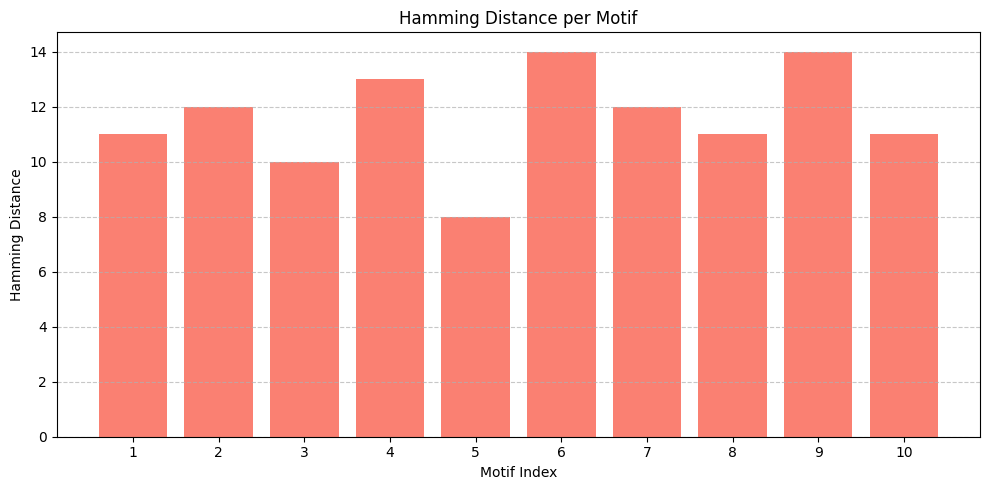

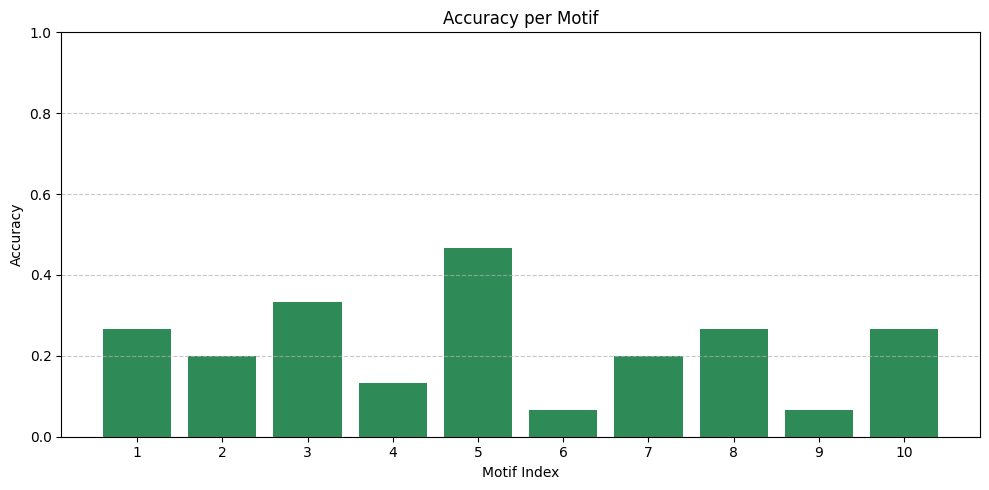

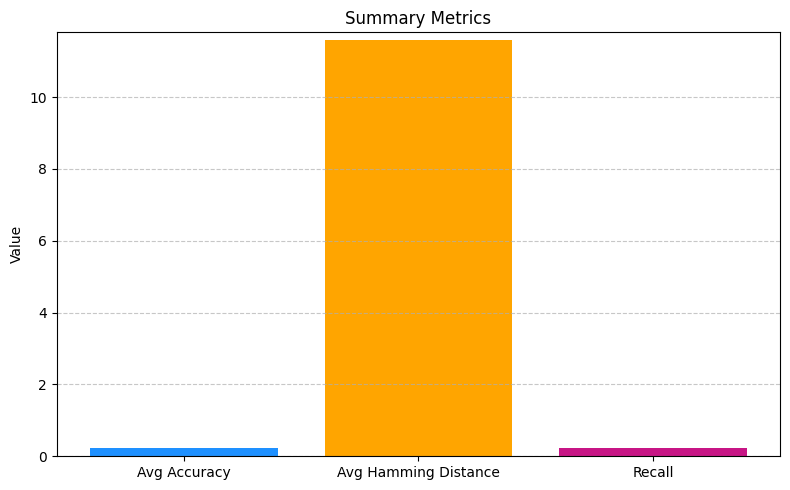

In [ ]:
import random
from collections import Counter

# Parameters
t = 10  # number of DNA strings
N = 100  # length of each string
k = 15  # motif length
d = 7   # max mutations

# DNA alphabet
nucleotides = ['A', 'C', 'G', 'T']

# Function to mutate a motif at up to d positions
def mutate_motif(motif, d):
    motif = list(motif)
    positions = random.sample(range(len(motif)), d)
    for pos in positions:
        original = motif[pos]
        motif[pos] = random.choice([n for n in nucleotides if n != original])
    return ''.join(motif)

# Generate consensus motif
def generate_consensus_motif(k):
    return ''.join(random.choice(nucleotides) for _ in range(k))

# Generate dataset with implanted motifs
def generate_dataset(t, N, k, d):
    sequences = []
    planted_motifs = []
    consensus = generate_consensus_motif(k)

    for _ in range(t):
        seq = list(''.join(random.choice(nucleotides) for _ in range(N)))
        mutated_motif = mutate_motif(consensus, d)
        start = random.randint(0, N - k)
        seq[start:start+k] = list(mutated_motif)
        sequences.append(''.join(seq))
        planted_motifs.append(mutated_motif)

    return sequences, planted_motifs, consensus

# Score motifs based on consensus
def score_motifs(motifs):
    consensus = ''
    for i in range(len(motifs[0])):
        col = [motif[i] for motif in motifs]
        most_common = Counter(col).most_common(1)[0][0]
        consensus += most_common
    score = sum(sum(1 for i in range(len(motif)) if motif[i] != consensus[i]) for motif in motifs)
    return score, consensus

# Build profile with pseudocounts
def build_profile(motifs):
    profile = {'A': [], 'C': [], 'G': [], 'T': []}
    k = len(motifs[0])
    for i in range(k):
        counts = Counter(motif[i] for motif in motifs)
        for base in nucleotides:
            profile[base].append((counts[base] + 1) / (len(motifs) + 4))  # pseudocounts
    return profile

# Find most probable k-mer in a sequence using a profile
def most_probable_kmer(seq, k, profile):
    max_prob = -1
    best_kmer = seq[0:k]
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        prob = 1
        for j, char in enumerate(kmer):
            prob *= profile[char][j]
        if prob > max_prob:
            max_prob = prob
            best_kmer = kmer
    return best_kmer

# Randomized Motif Search
def randomized_motif_search(sequences, k, iterations=1000):
    best_motifs = [random.choice([seq[i:i+k] for i in range(len(seq) - k + 1)]) for seq in sequences]
    best_score, _ = score_motifs(best_motifs)

    for _ in range(iterations):
        motifs = [random.choice([seq[i:i+k] for i in range(len(seq) - k + 1)]) for seq in sequences]
        while True:
            profile = build_profile(motifs)
            new_motifs = [most_probable_kmer(seq, k, profile) for seq in sequences]
            new_score, _ = score_motifs(new_motifs)
            if new_score < best_score:
                best_score = new_score
                best_motifs = new_motifs
                motifs = new_motifs
            else:
                break

    final_score, consensus = score_motifs(best_motifs)
    return best_motifs, final_score, consensus

# Run the setup and algorithm
sequences, planted_motifs, original_consensus = generate_dataset(t, N, k, d)
found_motifs, final_score, found_consensus = randomized_motif_search(sequences, k)

print("Original Consensus Motif: ", original_consensus)
print("Planted Motifs: ", planted_motifs)
print("Found Consensus Motif:   ", found_consensus)
print("Final Score: ", final_score)
print("Recovered Motifs:")
for motif in found_motifs:
    print(motif)
    # Function to calculate Hamming distance between two strings
def hamming_distance(s1, s2):
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

# Initialize totals
total_hamming = 0
total_correct = 0
total_possible = t * k
hamming_distances = []
accuracies = []

print("\nEvaluation Metrics:")
print("-------------------")

# Evaluate each pair of planted and recovered motifs
for i, (planted, recovered) in enumerate(zip(planted_motifs, found_motifs), 1):
    dist = hamming_distance(planted, recovered)
    correct = k - dist
    acc = correct / k

    hamming_distances.append(dist)
    accuracies.append(acc)

    total_hamming += dist
    total_correct += correct

    print(f"Motif {i}: Hamming Distance = {dist}, Accuracy = {acc:.2f}")

# Summary statistics
average_hamming = total_hamming / t
average_accuracy = total_correct / total_possible
recall = average_accuracy  # Same as accuracy in this case

print("\nSummary:")
print("--------")
print("Average Hamming Distance:", round(average_hamming, 2))
print("Overall Accuracy:", round(average_accuracy, 2))
print("Overall Recall:", round(recall, 2))

import matplotlib.pyplot as plt

# Plot Hamming Distance per Motif
plt.figure(figsize=(10, 5))
plt.bar(range(1, t+1), hamming_distances, color='salmon')
plt.xlabel('Motif Index')
plt.ylabel('Hamming Distance')
plt.title('Hamming Distance per Motif')
plt.xticks(range(1, t+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot Accuracy per Motif
plt.figure(figsize=(10, 5))
plt.bar(range(1, t+1), accuracies, color='seagreen')
plt.xlabel('Motif Index')
plt.ylabel('Accuracy')
plt.title('Accuracy per Motif')
plt.xticks(range(1, t+1))
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Summary Chart: Average Accuracy, Avg Hamming Distance, Recall
plt.figure(figsize=(8, 5))
metrics = [average_accuracy, average_hamming, recall]
labels = ['Avg Accuracy', 'Avg Hamming Distance', 'Recall']
colors = ['dodgerblue', 'orange', 'mediumvioletred']

plt.bar(labels, metrics, color=colors)
plt.ylabel('Value')
plt.title('Summary Metrics')
plt.ylim(0, max(metrics) + 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Original Consensus Motif:  TTTGTAACTGGCTAA
Planted Motifs:  ['TTAGTATCTGGATAA', 'TTAGTAATTGGCTTA', 'TTAGGAATTGGCTAA', 'TTTGTATCAGGCCAA', 'CTTGTATCTGGCTAT', 'TATGTAACTGGCAAT', 'TTTGAAACTGAATAA', 'TTTGGAACGGGTTAA', 'TGTGTAAGTGGCGAA', 'TTTGTAACGCGCTAC']
Found Consensus Motif:    TTTTGTAACTGGCTA
Final Score:  35
Recovered Motifs:
ATTAGTATCTGGATA
CTTAGTAATTGGCTT
TTTAGGAATTGGCTA
AAAAGCATCTGGCTA
TCTTGTATCTGGCTA
TTATGTAACTGGCAA
GTTTGAAACTGAATA
GTTTGGAACGGGTTA
TTGTGTAAGTGGCGA
ATTTGTAACGCGCTA

Evaluation Metrics:
-------------------
Motif 1: Hamming Distance = 12, Accuracy = 0.20
Motif 2: Hamming Distance = 10, Accuracy = 0.33
Motif 3: Hamming Distance = 8, Accuracy = 0.47
Motif 4: Hamming Distance = 12, Accuracy = 0.20
Motif 5: Hamming Distance = 13, Accuracy = 0.13
Motif 6: Hamming Distance = 11, Accuracy = 0.27
Motif 7: Hamming Distance = 9, Accuracy = 0.40
Motif 8: Hamming Distance = 7, Accuracy = 0.53
Motif 9: Hamming Distance = 11, Accuracy = 0.27
Motif 10: Hamming Distance = 12, Accuracy 

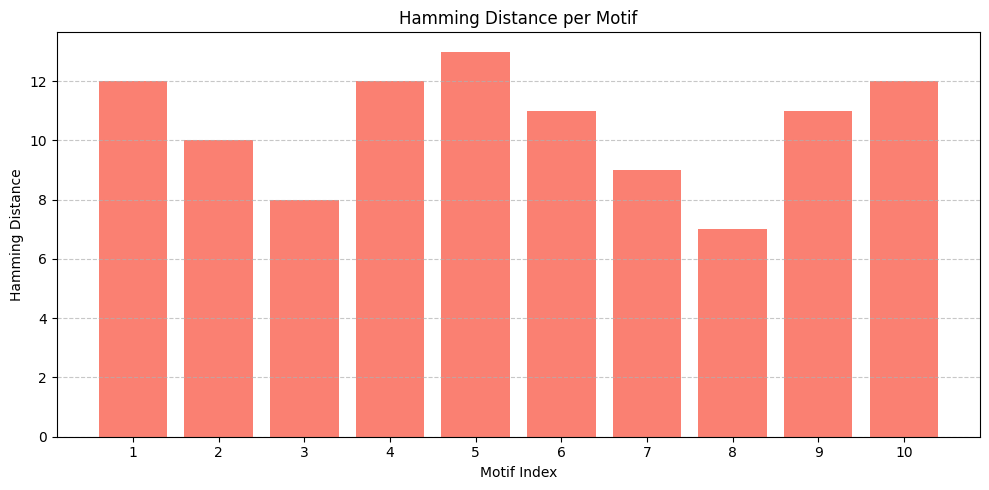

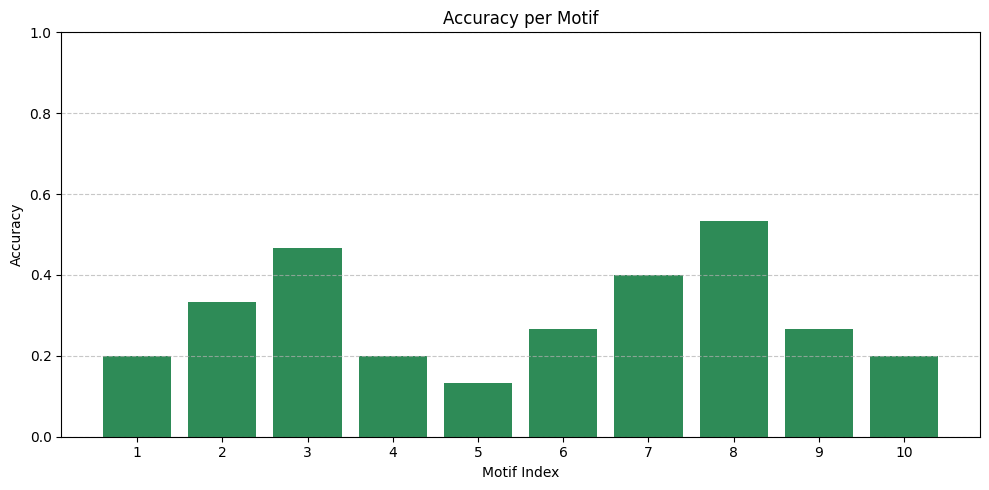

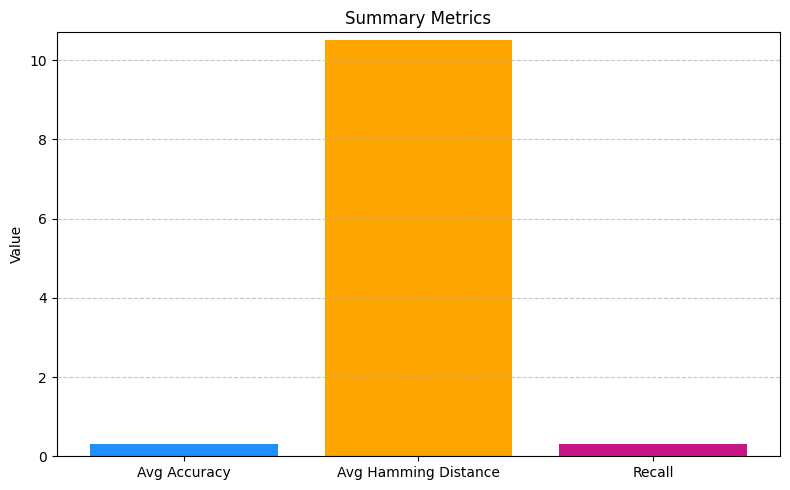

In [ ]:
import random
from collections import Counter

# Parameters
t = 10  # number of DNA strings
N = 100  # length of each string
k = 15  # motif length
d = 3   # max mutations

# DNA alphabet
nucleotides = ['A', 'C', 'G', 'T']

# Function to mutate a motif at up to d positions
def mutate_motif(motif, d):
    motif = list(motif)
    positions = random.sample(range(len(motif)), d)
    for pos in positions:
        original = motif[pos]
        motif[pos] = random.choice([n for n in nucleotides if n != original])
    return ''.join(motif)

# Generate consensus motif
def generate_consensus_motif(k):
    return ''.join(random.choice(nucleotides) for _ in range(k))

# Generate dataset with implanted motifs
def generate_dataset(t, N, k, d):
    sequences = []
    planted_motifs = []
    consensus = generate_consensus_motif(k)

    for _ in range(t):
        seq = list(''.join(random.choice(nucleotides) for _ in range(N)))
        mutated_motif = mutate_motif(consensus, d)
        start = random.randint(0, N - k)
        seq[start:start+k] = list(mutated_motif)
        sequences.append(''.join(seq))
        planted_motifs.append(mutated_motif)

    return sequences, planted_motifs, consensus

# Score motifs based on consensus
def score_motifs(motifs):
    consensus = ''
    for i in range(len(motifs[0])):
        col = [motif[i] for motif in motifs]
        most_common = Counter(col).most_common(1)[0][0]
        consensus += most_common
    score = sum(sum(1 for i in range(len(motif)) if motif[i] != consensus[i]) for motif in motifs)
    return score, consensus

# Build profile with pseudocounts
def build_profile(motifs):
    profile = {'A': [], 'C': [], 'G': [], 'T': []}
    k = len(motifs[0])
    for i in range(k):
        counts = Counter(motif[i] for motif in motifs)
        for base in nucleotides:
            profile[base].append((counts[base] + 1) / (len(motifs) + 4))  # pseudocounts
    return profile

# Find most probable k-mer in a sequence using a profile
def most_probable_kmer(seq, k, profile):
    max_prob = -1
    best_kmer = seq[0:k]
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        prob = 1
        for j, char in enumerate(kmer):
            prob *= profile[char][j]
        if prob > max_prob:
            max_prob = prob
            best_kmer = kmer
    return best_kmer

# Randomized Motif Search
def randomized_motif_search(sequences, k, iterations=1000):
    best_motifs = [random.choice([seq[i:i+k] for i in range(len(seq) - k + 1)]) for seq in sequences]
    best_score, _ = score_motifs(best_motifs)

    for _ in range(iterations):
        motifs = [random.choice([seq[i:i+k] for i in range(len(seq) - k + 1)]) for seq in sequences]
        while True:
            profile = build_profile(motifs)
            new_motifs = [most_probable_kmer(seq, k, profile) for seq in sequences]
            new_score, _ = score_motifs(new_motifs)
            if new_score < best_score:
                best_score = new_score
                best_motifs = new_motifs
                motifs = new_motifs
            else:
                break

    final_score, consensus = score_motifs(best_motifs)
    return best_motifs, final_score, consensus

# Run the setup and algorithm
sequences, planted_motifs, original_consensus = generate_dataset(t, N, k, d)
found_motifs, final_score, found_consensus = randomized_motif_search(sequences, k)

print("Original Consensus Motif: ", original_consensus)
print("Planted Motifs: ", planted_motifs)
print("Found Consensus Motif:   ", found_consensus)
print("Final Score: ", final_score)
print("Recovered Motifs:")
for motif in found_motifs:
    print(motif)
    # Function to calculate Hamming distance between two strings
def hamming_distance(s1, s2):
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

# Initialize totals
total_hamming = 0
total_correct = 0
total_possible = t * k
hamming_distances = []
accuracies = []

print("\nEvaluation Metrics:")
print("-------------------")

# Evaluate each pair of planted and recovered motifs
for i, (planted, recovered) in enumerate(zip(planted_motifs, found_motifs), 1):
    dist = hamming_distance(planted, recovered)
    correct = k - dist
    acc = correct / k

    hamming_distances.append(dist)
    accuracies.append(acc)

    total_hamming += dist
    total_correct += correct

    print(f"Motif {i}: Hamming Distance = {dist}, Accuracy = {acc:.2f}")

# Summary statistics
average_hamming = total_hamming / t
average_accuracy = total_correct / total_possible
recall = average_accuracy  # Same as accuracy in this case

print("\nSummary:")
print("--------")
print("Average Hamming Distance:", round(average_hamming, 2))
print("Overall Accuracy:", round(average_accuracy, 2))
print("Overall Recall:", round(recall, 2))

import matplotlib.pyplot as plt

# Plot Hamming Distance per Motif
plt.figure(figsize=(10, 5))
plt.bar(range(1, t+1), hamming_distances, color='salmon')
plt.xlabel('Motif Index')
plt.ylabel('Hamming Distance')
plt.title('Hamming Distance per Motif')
plt.xticks(range(1, t+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot Accuracy per Motif
plt.figure(figsize=(10, 5))
plt.bar(range(1, t+1), accuracies, color='seagreen')
plt.xlabel('Motif Index')
plt.ylabel('Accuracy')
plt.title('Accuracy per Motif')
plt.xticks(range(1, t+1))
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Summary Chart: Average Accuracy, Avg Hamming Distance, Recall
plt.figure(figsize=(8, 5))
metrics = [average_accuracy, average_hamming, recall]
labels = ['Avg Accuracy', 'Avg Hamming Distance', 'Recall']
colors = ['dodgerblue', 'orange', 'mediumvioletred']

plt.bar(labels, metrics, color=colors)
plt.ylabel('Value')
plt.title('Summary Metrics')
plt.ylim(0, max(metrics) + 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

